<a href="https://colab.research.google.com/github/RitikaHiremath/DataScience/blob/main/SVM_updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [30]:
import pandas as pd
import os

def load_and_label_data(base_path, label, max_files=None):
    combined_100KHzdata = []
    combined_2000KHzdata = []

    # Initialize a counter
    file_counter = 0

    # Iterate over each timestamped folder
    for timestamp_folder in os.listdir(base_path):
        if max_files and file_counter >= max_files:
            break

        timestamp_folder_path = os.path.join(base_path, timestamp_folder, "raw")

        # Extract the full timestamp from the folder name and convert to datetime format
        timestamp = timestamp_folder.split('_')[0] + '_' + timestamp_folder.split('_')[1]
        timestamp = pd.to_datetime(timestamp, format='%Y.%m.%d_%H.%M.%S')
        print(timestamp_folder_path)
        # Load the 2000KHz data
        df_2000KHz = pd.read_parquet(os.path.join(timestamp_folder_path, "Sampling2000KHz_AEKi-0.parquet"))
        mean_2000KHz = df_2000KHz.mean().to_frame().T
        mean_2000KHz['timestamp'] = timestamp
        mean_2000KHz['label'] = label

        # Load the 100KHz data
        df_100KHz = pd.read_parquet(os.path.join(timestamp_folder_path, "Sampling100KHz_Irms_Grinding-Grinding spindle current L1-Grinding spindle current L2-Grinding spindle current L3-0.parquet"))
        mean_100KHz = df_100KHz.mean().to_frame().T
        mean_100KHz['timestamp'] = timestamp
        mean_100KHz['label'] = label

        # Append the mean data to the combined lists
        combined_100KHzdata.append(mean_100KHz)
        combined_2000KHzdata.append(mean_2000KHz)

        # Increment the counter
        file_counter += 1

    # Combine all the mean data into a single dataframe
    final_combined_100KHzdata = pd.concat(combined_100KHzdata, ignore_index=True)
    final_combined_2000KHzdata = pd.concat(combined_2000KHzdata, ignore_index=True)

    return final_combined_100KHzdata, final_combined_2000KHzdata


# Define the paths to the OK and NOK data directories
ok_data_path = '/content/gdrive/MyDrive/Data/OK_Measurements'
nok_data_path = '/content/gdrive/MyDrive/Data/NOK_Measurements'

# Load OK and NOK data
ok_100KHzdata, ok_2000KHzdata = load_and_label_data(ok_data_path, label=0)
nok_100KHzdata, nok_2000KHzdata = load_and_label_data(nok_data_path, label=1)
# Combine OK and NOK data
all_100KHzdata = pd.concat([ok_100KHzdata, nok_100KHzdata], ignore_index=True)
all_2000KHzdata = pd.concat([ok_2000KHzdata, nok_2000KHzdata], ignore_index=True)

# Print the first few rows of the combined data for inspection
print("Combined 100KHz Data Sample (Mean):")
print(all_100KHzdata.head())
print("\nCombined 2000KHz Data Sample (Mean):")
print(all_2000KHzdata.head())


/content/gdrive/MyDrive/Data/OK_Measurements/2024.02.14_22.14.16_Grinding/raw
/content/gdrive/MyDrive/Data/OK_Measurements/2024.02.14_22.11.43_Grinding/raw
/content/gdrive/MyDrive/Data/OK_Measurements/2024.02.14_22.05.15_Grinding/raw
/content/gdrive/MyDrive/Data/OK_Measurements/2024.02.14_22.13.15_Grinding/raw
/content/gdrive/MyDrive/Data/OK_Measurements/2024.02.14_22.03.13_Grinding/raw
/content/gdrive/MyDrive/Data/OK_Measurements/2024.02.14_22.09.41_Grinding/raw
/content/gdrive/MyDrive/Data/OK_Measurements/2024.02.14_22.00.40_Grinding/raw
/content/gdrive/MyDrive/Data/OK_Measurements/2024.02.14_22.08.48_Grinding/raw
/content/gdrive/MyDrive/Data/OK_Measurements/2024.02.14_22.12.44_Grinding/raw
/content/gdrive/MyDrive/Data/OK_Measurements/2024.02.14_22.06.46_Grinding/raw
/content/gdrive/MyDrive/Data/OK_Measurements/2024.02.14_22.02.12_Grinding/raw
/content/gdrive/MyDrive/Data/OK_Measurements/2024.02.14_22.01.11_Grinding/raw
/content/gdrive/MyDrive/Data/OK_Measurements/2024.02.14_22.04.44

In [41]:
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
def combine_and_interpolate_data(data_100KHz, data_2000KHz):
    # Merge on timestamp
    combined_data = pd.merge_asof(data_100KHz.sort_values('timestamp'),
                                  data_2000KHz.sort_values('timestamp'),
                                  on='timestamp',
                                  by='label',
                                  direction='nearest')

    # Interpolate to fill missing values
    combined_data = combined_data.interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')

    return combined_data

def normalize_data(combined_data):
    features = combined_data.drop(columns=['timestamp', 'label'])
    timestamps = combined_data['timestamp']
    labels = combined_data['label']

    scaler = StandardScaler()
    normalized_features = scaler.fit_transform(features)

    normalized_data = pd.DataFrame(normalized_features, columns=features.columns)
    normalized_data.insert(0, 'timestamp', timestamps)
    normalized_data['label'] = labels.values

    return normalized_data

combined_data = combine_and_interpolate_data(all_100KHzdata, all_2000KHzdata)

# Normalize data
normalized_data = normalize_data(combined_data)

# Shuffle the combined data
normalized_data = shuffle(normalized_data, random_state=42)

In [6]:
normalized_data

,timestamp,Irms_Grinding_rate100000_clipping0_batch0,Grinding spindle current L1_rate100000_clipping0_batch0,Grinding spindle current L2_rate100000_clipping0_batch0,Grinding spindle current L3_rate100000_clipping0_batch0,AEKi_rate2000000_clipping0_batch0,label
0,2024-02-14 22:00:10,-1.213932,0.410776,-0.126537,-0.436171,-1.575957,0
5,2024-02-14 22:02:42,-1.183331,-0.471785,-1.769435,-1.283035,-1.495238,0
34,2024-02-15 02:29:55,0.527815,-1.771280,-1.287229,-0.227444,0.265340,1
13,2024-02-14 22:06:46,-0.948118,-0.687227,-1.421435,-0.871137,-0.545303,0
44,2024-02-15 02:34:35,1.222974,-0.031644,0.330135,1.320887,1.008582,1
52,2024-02-15 02:38:16,1.283167,-2.178558,-1.264383,0.450387,1.975277,1
37,2024-02-15 02:31:16,0.779001,0.058446,0.864113,1.127915,1.538123,1
25,2024-02-14 22:13:15,-0.892442,-0.288736,0.345105,1.022474,-1.565786,0
46,2024-02-15 02:35:32,1.241709,-0.278510,1.022761,2.211564,0.760055,1
12,2024-02-14 22:06:15,-0.990189,-1.145985,-0.672976,0.475609,-0.422105,0


In [32]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

In [42]:

X=normalized_data.iloc[:,1:-1]
y=normalized_data['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=65)


In [44]:
svm = SVC(kernel='poly', C=1.5, random_state=42)
svm.fit(X_train, y_train)

y_pred = svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("\nClassification Report:\n", report)

Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00        12

    accuracy                           1.00        18
   macro avg       1.00      1.00      1.00        18
weighted avg       1.00      1.00      1.00        18



              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00        12

    accuracy                           1.00        18
   macro avg       1.00      1.00      1.00        18
weighted avg       1.00      1.00      1.00        18



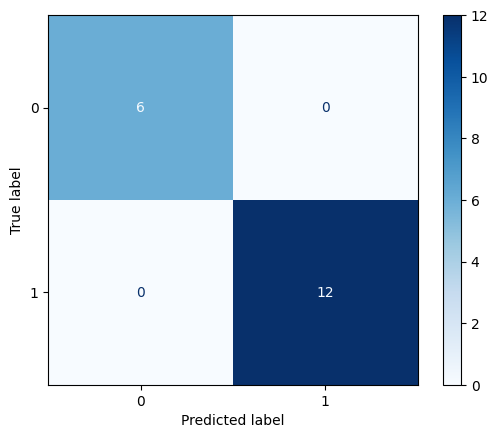

In [40]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
# Evaluate the model on training data
y_pred = svm.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype("int32")
print(classification_report(y_test, y_pred_classes))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.show()
# train_loss, train_accuracy, train_precision, train_recall = svm.evaluate(X_train, y_train)
# print(f"Training Accuracy: {train_accuracy*100:.2f}%")

# # Evaluate the model on test data
# test_loss, test_accuracy, test_precision, test_recall = svm.evaluate(X_test, y_test)
# print(f"Test Accuracy: {test_accuracy*100:.2f}%")

# # Evaluate the model and print classification report
# evaluate_model(model_combined, X_test, y_test)